In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colossus
from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_so, profile_nfw
from plotter import plot, loglogplot
from scipy.interpolate import InterpolatedUnivariateSpline as interp
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
import subprocess
from os import getcwd
import warnings
%matplotlib inline

In [2]:
# will need to test sensitivity to:
# 1. c(M,z) relationship: Zhao+09, Duffy+08, Diemer+19
# 2. MAH model: Zhao+09, vdB+14, Parkinson+08 merger trees
# 3. Various cosmologies

In [3]:
# global variables
# free parameters of Shi+14 model; can be changed later
beta_def = 1.0
eta_def  = 0.7

G = colossus.utils.constants.G
cm_per_km = 1e5
km_per_kpc = colossus.utils.constants.KPC / cm_per_km # KPC was in cm
s_per_Gyr = colossus.utils.constants.GYR
yr_per_Gyr = 1E9

# can reset cosmology on-the-fly, will start with WMAP 5
cosmo = cosmology.setCosmology('WMAP5')
cosmo_astro = FlatLambdaCDM(H0=cosmology.getCurrent().H0 * u.km / u.s / u.Mpc, Tcmb0=cosmology.getCurrent().Tcmb0 * u.K, Om0=cosmology.getCurrent().Om0, Neff=cosmology.getCurrent().Neff, Ob0=cosmology.getCurrent().Ob0)
print(cosmology.getCurrent())

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


Text(0, 0.5, '$c$')

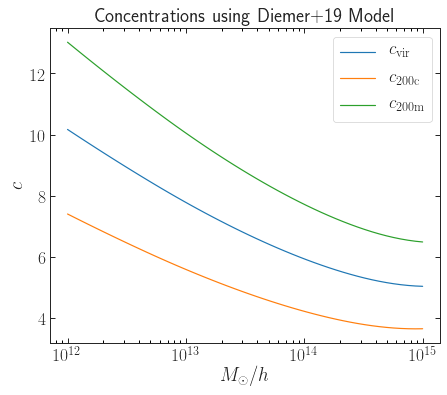

In [5]:
# mass-concentration relationships
# Original Shi paper used duffy08 and vdB+14 used the c(M,z) of Zhao+09
# need to make sure that we use consistent definitions of virial radius, thus concentration, everywhere
# takes the z=0 mass in units of Msun/h
nm = 50
masses = np.logspace(12,15,nm)
cvirs = concentration.concentration(masses, 'vir', 0.0, model = 'diemer19')
c200cs = concentration.concentration(masses, '200c', 0.0, model = 'diemer19')
c200ms = concentration.concentration(masses, '200m', 0.0, model = 'diemer19')
plot(semilogx=True)
plt.plot(masses, cvirs, label=r'$c_\mathrm{vir}$')
plt.plot(masses, c200cs, label=r'$c_\mathrm{200c}$')
plt.plot(masses, c200ms, label=r'$c_\mathrm{200m}$')
plt.title(r'Concentrations using Diemer+19 Model')
plt.legend()
plt.xlabel(r'$M_\odot / h$')
plt.ylabel(r'$c$')

# TODO: vdB+14 uses Zhao et al. 2009, not available in Colossus, so may need to code that up
# this uses the lookback time instead of redshift, so need to get z from t
# NOTE: vdB+14 paper and code use slightly different formulas
# We probably want to use one of the all-cosmology c(M,z) since we will use different definitions of the virial radius

In [6]:
# computing t_d from t_dyn
# the masses are in Msun/h
# the lengths for haloes are in kpc/h
def NFWf(x):
    return np.log(1. + x) - x/(1. + x)

# accepts radius in physical kpc/h
# might change this...
def NFWM(r, M, z, conc_model='diemer19', mass_def='vir'):
    # compute the concentration
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    return M * NFWf(c*r/R) / NFWf(c)

def t_d(r, M, z, conc_model='diemer19', mass_def='vir', beta=beta_def):
    Menc = NFWM(r, M, z, conc_model, mass_def)
    t_dyn = 2. * np.pi * (r**3 / (G*Menc))**(1./2.) * km_per_kpc / (cosmology.getCurrent().H0 / 100.)
    return beta * t_dyn / s_per_Gyr / 2.

6.242115649063551


Text(0, 0.5, '$t_\\mathrm{d}$ [Gyr]')

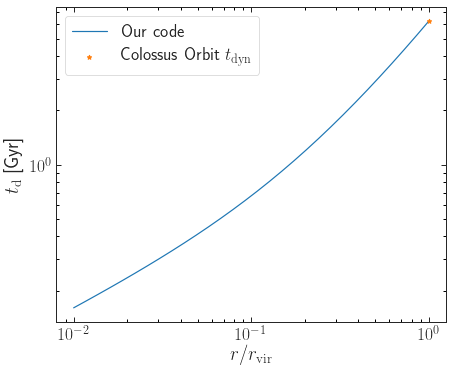

In [7]:
# look at t_d vs. r for a 10^14 Msun/h halo to verify the results

mass = 1e14 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

dt = mass_so.dynamicalTime(0.0, 'vir', definition='orbit')
print(dt / 2)

loglogplot()
plt.plot(rads/Rvir, t_d(rads, mass, 0.0, mass_def='vir'), label=r'Our code')
plt.plot([1.], [dt/2], '*', label=r'Colossus Orbit $t_\mathrm{dyn}$')
plt.legend()
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$t_\mathrm{d}$ [Gyr]')
# it agrees, so our calculation seems to be correct
# it disagrees by ~factor of 2~ with Shi and Komatsu, which is explained in their erratum
# hence, our result is indeed correct
# need to check later results to see if they actually use beta*t_dyn / 2 or beta*t_dyn for further stuff

In [8]:
# Komatsu and Seljak Model
# Here, c_nfw is defined using the virialization condition of Lacey & Cole (1993) and Nakamura & Suto (1997)
# should make sure that it is pretty similar to Bryan and Norman

def Gamma(c_nfw):
    return 1.15 + 0.01*(c_nfw - 6.5)

def eta0(c_nfw):
    return 0.00676*(c_nfw - 6.5)**2 + 0.206*(c_nfw - 6.5) + 2.48

def NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    if(type(r) != np.ndarray and r == 0):
        return -1. * (G * M / R) * (c / NFWf(c))
    else:
        return -1. * (G * M / R) * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))

# this now agrees with Komatsu and Seljak eqn 19 for theta
# the confusion was that rho0 / P0 is 3*eta0^-1 and then units removed by scaling by R/GM
def theta(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    # the rho0/P0 is actually 3eta^-1(0) * R/(GM) from Komatsu and Seljak
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return 1. + ((Gamma(c) - 1.) / Gamma(c))*rho0_by_P0*(NFWPhi(0, M, z, conc_model='diemer19', mass_def='vir')-NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'))

# arbitrary units for now while we figure out what to do with the normalization
# likely won't need this
def rho_gas(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    return theta(r, M, z, conc_model, mass_def)**(1.0 / (Gamma(c) - 1.0))

# in km/s
def sig2_tot_obsolete(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return (1.0 / rho0_by_P0) * theta(r, M, z, conc_model, mass_def)

# the complete sig2_tot that only makes one of each relevant function call:
def sig2_tot(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model) # tabulated probably
    R = mass_so.M_to_R(M, z, mass_def) # tabulated probably
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

# concentration increases with time
# radius also increases with time (hence why c increases)

Text(0, 0.5, '$\\frac{\\Gamma}{\\Gamma - 1}$')

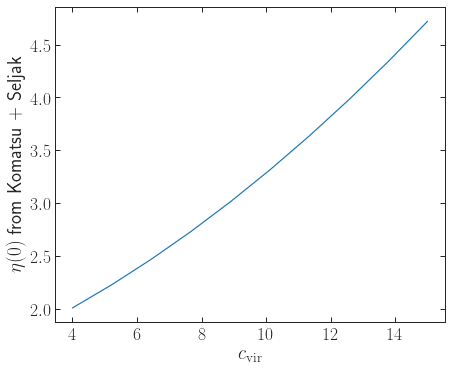

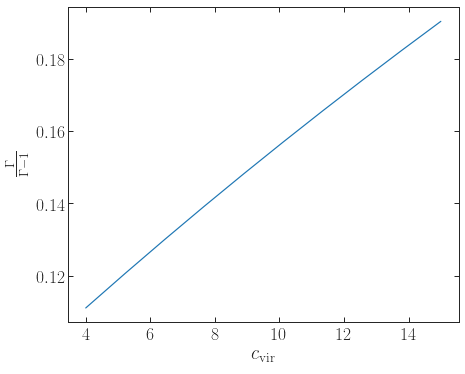

In [9]:
concs = np.linspace(4,15,10)
plot()
plt.plot(concs, eta0(concs))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\eta(0)$ from Komatsu + Seljak')
plot()
plt.plot(concs, ((Gamma(concs) - 1.) / Gamma(concs)))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\frac{\Gamma}{\Gamma - 1}$')

Text(0, 0.5, '$\\sigma_\\mathrm{tot}$ [km/s]')

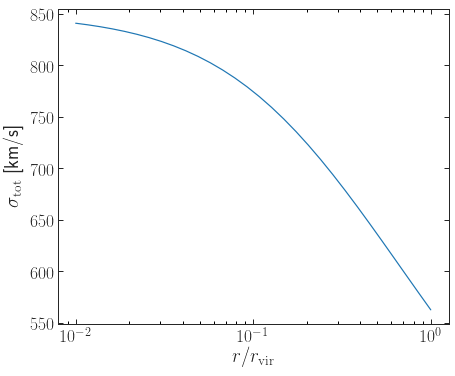

In [10]:
mass = 10**14.5 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

plot(semilogx=True)
plt.plot(rads/Rvir, (sig2_tot(rads, mass, 0.0, mass_def='vir'))**(1./2.))
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{tot}$ [km/s]')

# what happens to Komatsu-Seljak model when you have c < 6.5?

# we now have recovered the result of Fig 4 from Komatsu and Seljak

In [11]:
zhao_exec_name = 'mandc.x'
vdb_exec_name = 'getPWGH'

# TODO: Update the calls to use names that change with the cosmology
# then we can check for the presence of a file for a given combo of m, z, and cosmo
# and if it is there already, we don't need to regenerate it
# this will speed up the reproduction of plots

# can convert to 200c, 200m if needed
def zhao_mah(Mobs, z_obs, cosmo):
    lgMobs = np.log10(Mobs)
    instring = 'nthpre\n%.3f %.3f\n1\n%.3f\n%.3f\n%.3f\n%.4f %1.3f\n1\n%1.1f\n%2.1f' % (cosmo.Om0, cosmo.Ode0, cosmo.H0/100., cosmo.sigma8, cosmo.ns, cosmo.Ob0, cosmo.Tcmb0, z_obs, lgMobs)
    command = "echo '%s' | %s/%s" % (instring, getcwd(), zhao_exec_name)
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process.wait()
    # load in data file
    zpt = '%05d' % (np.round(z_obs, decimals=1)*100)
    mpt = '%05d' % (np.round(lgMobs, decimals=1)*100)
    df_name = 'mchistory_nthpre.%s.%s' % (zpt, mpt)
    data = np.loadtxt(df_name,skiprows=1)
    # will update the line below if we want to use 200c/200m
    zeds = data[:,0]; mass = data[:,1]; conc = data[:,2]
    times = data[:,-1] / yr_per_Gyr / (cosmo.H0/100.);
    # wonder how sensitive the results are to the derivative method used
    dMdt = (mass[1:] - mass[:-1]) / (times[1:] - times[:-1])
    # setting the dMdt at present day to zero since we don't need to evolve past z=0
    dMdt = np.insert(dMdt, len(dMdt), 0)
    out = np.column_stack((zeds, mass, conc, dMdt))
    out = np.flip(out, axis=0)
    return(out)

# same units for both, dM/dt in Msun/h / Gyr, mass in Msun/h

def vdb_mah(Mobs, z_obs, cosmo, tp='average'):
    if(tp=='median'):
        med_or_avg = 0
    elif(tp=='average'):
        med_or_avg = 1
    instring = '%.3f\n%.3f\n%.3f\n%.3f\n%.4f\n%1.1E\n%1.1f\n%1d' % (cosmo.Om0, cosmo.H0/100., cosmo.sigma8, cosmo.ns, cosmo.Ob0*(cosmo.H0/100.)**2, Mobs, z_obs, med_or_avg)
    command = "echo '%s' | %s/%s" % (instring, getcwd(), vdb_exec_name)
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process.wait()
    # load in data file
    df_name = 'PWGH_%s.dat' % tp
    data = np.loadtxt(df_name)
    zeds = data[:,1]; mass = 10**data[:,3] * Mobs
    conc = data[:,6]; dMdt = data[:,7] * yr_per_Gyr
    out = np.column_stack((zeds, mass, conc, dMdt))
    out = np.flip(out, axis=0)
    return(out)

# will want to do the same thing here with the Parkinson model, but give it a third dimension which corresponds to
# the number of trees


Text(0, 0.5, '$M$')

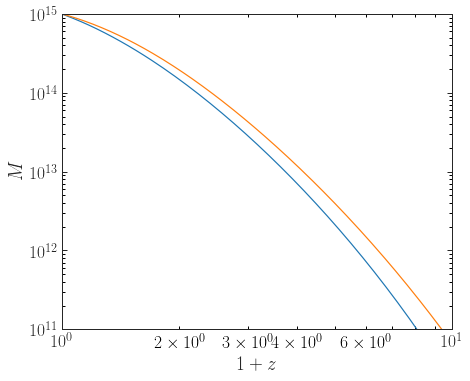

In [12]:
zd = zhao_mah(10**15, 0.0, cosmo)
vd = vdb_mah(10**15, 0.0, cosmo)

loglogplot()
plt.plot(1+zd[:,0],zd[:,1], label='Zhao+09')
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14')
plt.xlim(1,10)
plt.ylim(10**11,10**15)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M$')

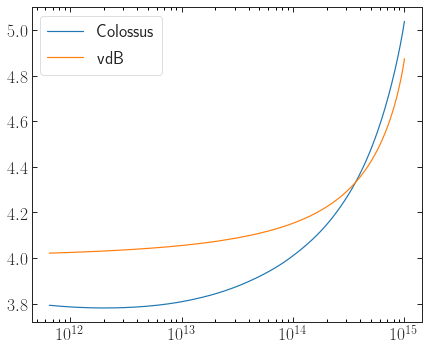

In [15]:
vdb_dat = vdb_mah(10**15, 0.0, cosmo)

masses = vdb_dat[:,1]
zeds = vdb_dat[:,0]
msk = zeds <= 6
vdb_concs = vdb_dat[:,2]
concs = np.zeros(len(vdb_dat))
for i in range(0,len(concs)):
    concs[i] = concentration.concentration(masses[i], 'vir', zeds[i], model = 'diemer19')

plot(semilogx=True)
plt.plot(masses[msk], concs[msk], label='Colossus')
plt.plot(masses[msk], vdb_concs[msk], label='vdB')
plt.legend()

0.008233118259693672 0.3467672404220167


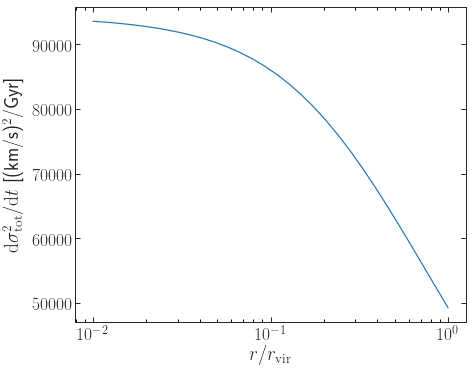

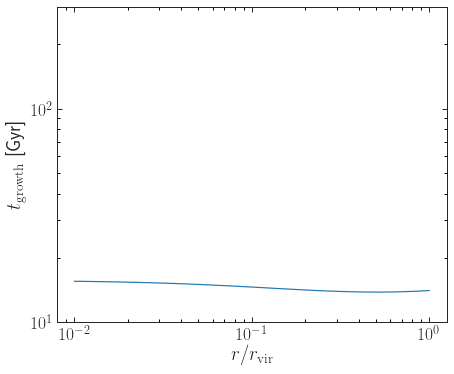

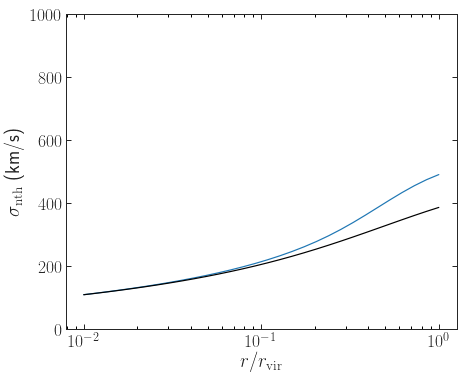

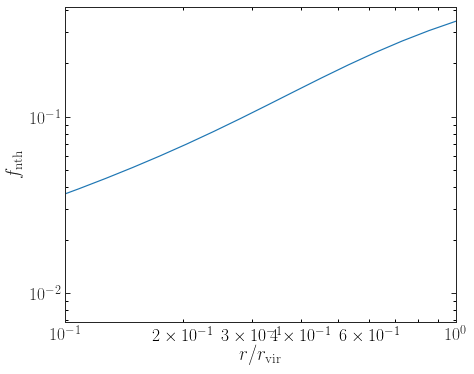

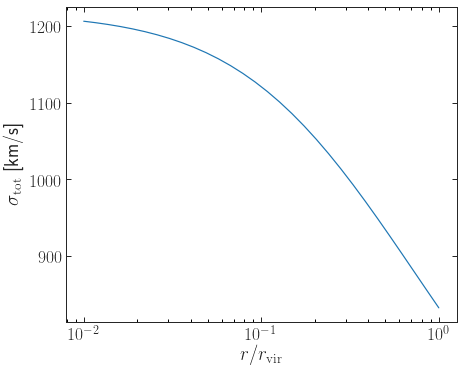

In [16]:
warnings.simplefilter('ignore')
cosmo = cosmology.setCosmology('WMAP5')
# pipeline takes in Mobs, z, cosmology
# computes the dsigma^2/dt for each radius

Mobs = 10**15
zobs = 0.0
mass_def = 'vir'
conc_model='duffy08' # will definitely want to try changing this
nrads = 30

# need to make sure that when we change the cosmology, all things are properly updated

zhao_dat = zhao_mah(Mobs, zobs, cosmo)
first_snap_to_use = np.where(zhao_dat[:,0] <= 6.)[0][0] - 1
zhao_dat = zhao_dat[first_snap_to_use:]

def sig2_tot(r, M, c, R):
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

n_steps = zhao_dat.shape[0] - 1

Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

ds2dt = np.zeros((n_steps, nrads))
sig2tots = np.zeros((n_steps, nrads))
sig2nth = np.zeros((n_steps, nrads))

for i in range(0, n_steps):
    z_1 = zhao_dat[i,0] #first redshift
    z_2 = zhao_dat[i+1,0] #second redshift, the one we are actually at
    dt = cosmo.age(z_2) - cosmo.age(z_1) # in Gyr
    mass_1 = zhao_dat[i,1]
    mass_2 = zhao_dat[i+1,1]
    dM = mass_2 - mass_1
    dMdt = zhao_dat[i+1,3] # since the (i+1)th is computed between i+1 and i
    R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
    R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
    c_1 = concentration.concentration(mass_1, mass_def, z_1, model = 'duffy08') #zhao_dat[i,2]
    c_2 = concentration.concentration(mass_2, mass_def, z_2, model = 'duffy08') #zhao_dat[i+1,2]
    sig2tots[i,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
    if(i==0):
        # update this to accept general eta
        ds2dt[i,:] = (sig2tots[i,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
        sig2nth[i,:] = eta_def * sig2tots[i,:] # starts at z_i = 6 roughly
    else:
        ds2dt[i,:] = (sig2tots[i,:] - sig2tots[i-1,:]) / dt
        td = t_d(rads, mass_2, z_2, conc_model, mass_def, beta=beta_def) #t_d at z of interest z_2
        sig2nth[i,:] = sig2nth[i-1] + ((-1. * sig2nth[i-1,:] / td) + eta_def * ds2dt[i,:])*dt
        # here we can see if it is td or 2td that we are using in comparison



plot(semilogx=True)
plt.plot(rads/Robs, ds2dt[-1,:])
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\mathrm{d}\sigma_\mathrm{tot}^2 /\mathrm{d}t$ [(km/s)$^2$/Gyr]')

tgrowth = sig2tots / np.abs(ds2dt)
loglogplot() 
plt.plot(rads/Robs, tgrowth[-1,:])
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$t_\mathrm{growth}$ [Gyr]')
plt.ylim(10**1, 3*10**2)

td = t_d(rads, zhao_dat[-1,1], zhao_dat[-1,0], conc_model, mass_def, beta=beta_def)
fnth_lim = eta_def * td / (td + tgrowth[-1,:])

plot(semilogx=True)
plt.plot(rads/Robs, np.sqrt(sig2nth[-1,:]))
plt.plot(rads/Robs, np.sqrt(fnth_lim) * np.sqrt(sig2tots[-1,:]), color='k')
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{nth}$ (km/s)')
plt.ylim(0,1000)

loglogplot()
fnth = sig2nth[-1,:] / sig2tots[-1,:]
print(np.min(fnth),np.max(fnth)) # currently not changing much... still a bug
plt.plot(rads/Robs, fnth)
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$f_\mathrm{nth}$')
plt.xlim(10**-1, 1.)

plot(semilogx=True)
plt.plot(rads/Robs, np.sqrt(sig2tots[-1,:])) # this is correct still
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{tot}$ [km/s]')

# once we can *roughly* reproduce the results of Shi+14, we're ready to start trying different masses, redshifts, cosmos
warnings.simplefilter('default')

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2


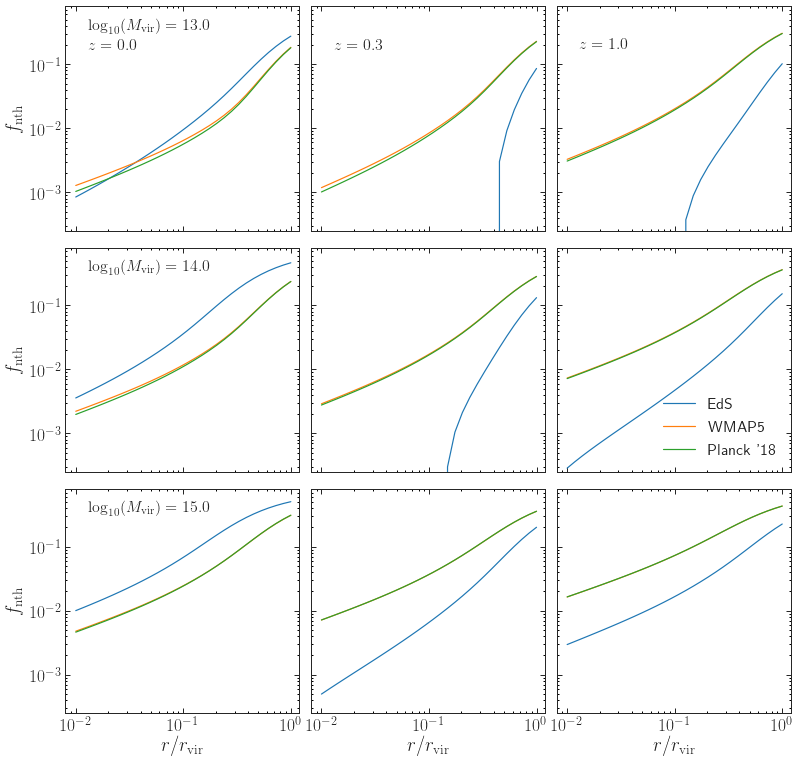

In [17]:
warnings.simplefilter('ignore')
# let's make a function out of the stuff below and then loop over several masses and redshifts
# then we can add in cosmologies

def sig2_tot(r, M, c, R):
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

#takes in Mobs, zobs, cosmo
#returns f_nth, sig2nth, sig2tot at z=zobs
def gen_fnth(Mobs, zobs, cosmo, mah_retriever=zhao_mah, mass_def='vir', conc_model='duffy08', beta=beta_def, eta=eta_def):
    data = mah_retriever(Mobs, zobs, cosmo)
    first_snap_to_use = np.where(data[:,0] <= 6.)[0][0] - 1
    data = data[first_snap_to_use:]

    n_steps = data.shape[0] - 1

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

    ds2dt = np.zeros((n_steps, nrads))
    sig2tots = np.zeros((n_steps, nrads))
    sig2nth = np.zeros((n_steps, nrads))

    for i in range(0, n_steps):
        z_1 = data[i,0] #first redshift
        z_2 = data[i+1,0] #second redshift, the one we are actually at
        dt = cosmo.age(z_2) - cosmo.age(z_1) # in Gyr
        mass_1 = data[i,1]
        mass_2 = data[i+1,1]
        dM = mass_2 - mass_1
        dMdt = data[i+1,3] # since the (i+1)th is computed between i+1 and i
        R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
        R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
        c_1 = concentration.concentration(mass_1, mass_def, z_1, model=conc_model) #zhao_dat[i,2]
        c_2 = concentration.concentration(mass_2, mass_def, z_2, model=conc_model) #zhao_dat[i+1,2]
        sig2tots[i,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
        if(i==0):
            # update this to accept general eta
            ds2dt[i,:] = (sig2tots[i,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
            sig2nth[i,:] = eta_def * sig2tots[i,:] # starts at z_i = 6 roughly
        else:
            ds2dt[i,:] = (sig2tots[i,:] - sig2tots[i-1,:]) / dt
            td = t_d(rads, mass_2, z_2, conc_model, mass_def, beta=beta_def) #t_d at z of interest z_2
            sig2nth[i,:] = sig2nth[i-1] + ((-1. * sig2nth[i-1,:] / td) + eta_def * ds2dt[i,:])*dt
    fnth = sig2nth[-1,:] / sig2tots[-1,:]
    return fnth, rads, sig2nth[-1,:], sig2tots[-1,:]


masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['EdS','WMAP5','planck18']
fancy_cosms = ['EdS', 'WMAP5', "Planck '18"]

fig, ax = plt.subplots(nrows=len(masses),ncols=len(zeds),figsize=(13,13), sharex=True, sharey=True, gridspec_kw={'wspace':0.05,'hspace':0.075})
for i in range(0,3):
    for j in range(0,3):
        ax[i,j].yaxis.set_ticks_position('both')
        ax[i,j].xaxis.set_ticks_position('both')
        ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
        ax[i,j].loglog()
        ax[i,j].set_ylim(2.5e-4,0.8)
        ax[i,j].set_xlim(0.8*1e-2,1*1.2)
        #ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.2))
        #ax[i,j].yaxis.set_minor_locator(MultipleLocator(0.05))


# can generate colors based on the cosmology

for i,m in enumerate(masses):
    for j,z in enumerate(zeds):
        for k,cosm in enumerate(cosmologies):
            print(i,j,k)
            cosmo = cosmology.setCosmology(cosm)
            fnth, rads, _, _ = gen_fnth(m, z, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='duffy08', beta=beta_def, eta=eta_def)
            ax[i,j].plot(rads/rads[-1], fnth, label=fancy_cosms[k])


for i in range(0,len(masses)):
    ax[i,0].set_ylabel(r'$f_\mathrm{nth}$')
    ax[i,0].text(1.3e-2,3e-1,r'$\log_{10}(M_\mathrm{vir})=%.1f$' % np.log10(masses[i]), fontsize=16)
for i in range(0,len(zeds)):
    ax[len(masses)-1,i].set_xlabel(r'$r/r_\mathrm{vir}$')
    ax[0,i].text(1.3e-2,1.7e-1,r'$z=%.1f$' % zeds[i], fontsize=16)

ax[1,len(zeds)-1].legend(frameon=False,fontsize=16)

# clearly, the different cosmologies look different, but this is sensitive to concentration definition
# we can see how different things are using different concentration definitions and using vdB vs. Zhao
warnings.simplefilter('default')